# Analiza danych o zanieczyszczeniu powietrza (Airly)

#### Przemysław Moskała środa 17:45

Analiza danych o zanieczyszczeniu powietrza (Airly)
- Zbiór danych:
    – https://developer.airly.eu/docs#endpoints.measurements
- Wykorzystaj dane z czujników jakości powietrza do segmentacji obszaru Krakowa na podobszary charakteryzujące się podobną dynamiką zmian jakości powietrza
- Na podstawie danych historycznych oblicz następujące wskaźniki ilościowe jakości powietrza (na podobszar):
– Najdłuższy ciągły okres, w którym norma została przekroczona w danych podobszarze (rozdzielczość godzinowa)
– Najgorsza średnia jakość powietrza w danym okresie czasu
- Zaproponuj metodę pozwalającą na modyfikację rozdzielczości podobszarów (klastrów)
- Przedstaw wizualizację wyników analizy

## Zbieranie danych

API udostępniane przez Airly przechowuje dane z ostatnich 24 godzin dla każdej stacji. Proces zbierający dane powinien się więc uruchamiać co najmniej raz na 24H. Dodatkowo API posiada limity:
- 50 zapytań na minute
- 1000 zapytań na dzień



Wobec tego postanowiłem użyć Apache NiFi jako narzędzia do zbudowania procesu zbierającego dane.
Proces ten uruchamiał sie co 24H i działał następująco:
1. Odpytał o stacje w odległości 20km od centrum Krakowa
2. Przefiltrował stacje które w metadanych miały miasto "Kraków"
3. Dla każdej stacji wysłał zapytanie o historyczne pomiary z ostatnich 24h, z throttlingiem 50 req/min
4. Zapisał odpowiedź w bazie MySQL.

<img src="nifi.png">

## Analiza danych

Rozdzielczość czasowa danych na stacja wynosi jedną godzinę.
Nie wszystkie stacje miały takie same czujniki, zbiór wszystkich czujników ze wszystkich stacji to:
- PM1
- PM10
- PM25
- tlenek węgla CO
- ciśnienie powietrza
- wilgotoność
- temeratura
- ozon O3
- tlenek siarki SO2
- dwuletek azotu NO2

### Imports

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn
from IPython.display import Image as PImage
from subprocess import check_call
import itertools
import json
from datetime import timedelta
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, Birch
import dateutil.parser
import numpy as np
import os
import matplotlib as mpl
import datetime
import warnings
warnings.filterwarnings('ignore')


### Constans

In [2]:
FIRST_MEASURE = datetime.datetime(2019, 10, 23)

MEASURE_DIM = 10
PM1_DIM = 0
PM10_DIM = 1
PM25_DIM = 2
NO2_DIM = 3
CO_DIM = 4
PRESSURE = 5
HUMIDITY = 6
TEMPERATURE = 7
SO2 = 8
O3 = 9
AIRLY_CAQI = 6
HOURS = 24
NORMS_DICT = {
    PM1_DIM: np.nan,
    PM10_DIM: 25,
    PM25_DIM: 50,
    NO2_DIM: 200,
    CO_DIM: np.nan,
    PRESSURE: np.nan,
    HUMIDITY : np.nan,
    TEMPERATURE: np.nan,
    SO2 : np.nan,
    O3: np.nan
}
COLUMNS = ['PM1', 'PM10', 'PM25', 'NO2', 'CO', 'PRESSURE', 'HUMIDITY', 'TEMEPRATURE']

DELTA_MEASURE = 0
MEASURE_VALUE = 1
NORMS = 2
DATE = 3

### Utility functions

In [3]:
def read_json(path):
    with open(path) as json_file:
        content = json.load(json_file)
        return content

def read_stations(content):
    grouped = itertools.groupby(content, lambda e: e['id'])
    station_map = {}
    for i in grouped:
        for j in i[1]:
            station_map[j['id']] = j
    return station_map

def group(col, by):
    values = set(map(lambda e: e[by], col))
    return [[y for y in col if y[by] == x] for x in values]


def read_first_measure_ids(content):
    return [m['id'] for m in (sorted(group(content, 'date'), key=lambda e: e[0]['date'])[0])]

def get_cords(stations_map, STATION_IDS):
    return [(station, stations_map[station]['location']) for station in STATION_IDS]


def extract_days(content, station):
    history = [json.loads(e['measure']).get('history') for e in list(filter(lambda x:
                                                                  x[0]['id'] == station,
                                                                  group(content, 'id')))[0]]
    dates = [[dateutil.parser.parse(d['fromDateTime']).date() for d in h] for h in filter(None, history)]
    return sorted(set(itertools.chain.from_iterable(dates)))


def triangulate(station_with_cords):
    points = np.array([[station[1]['latitude'], station[1]['longitude']] for station in station_with_cords])
    from scipy.spatial import Delaunay
    tri = Delaunay(points)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(50,30))
    ax = fig.add_subplot(111)
    X = points[:, 1]
    Y = points[:, 0]
    plt.triplot(X, Y, tri.simplices.copy())
    plt.plot(X, Y, 'o')
    i = 0
    for xy in zip(X, Y):
        ax.annotate('%s' % i, xy=xy, textcoords='data', size=40)
        i = i + 1
    plt.show()

    return tri.simplices.copy()


def draw_for(measure_matrix, triangles, station_with_cords, day, hour,m,i,DAYS):
    import matplotlib.pyplot as plt
    points = np.array([[station[1]['latitude'], station[1]['longitude']] for station in station_with_cords])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("{} {}".format(DAYS[day], h))
    X = points[:, 0]
    Y = points[:, 1]
    Z = measure_matrix[:, day, hour,m,i]
    tpc = plt.tripcolor(X, Y, Z, triangles)
    fig.colorbar(tpc)
    plt.plot(X, Y, 'o')
    i = 0
    for xy in zip(X, Y):  # <--
        ax.annotate('%s' % i, xy=xy, textcoords='data')
        i = i + 1
    plt.show()

    
def get_prev(day, hour):
    if hour > 0:
        return day, hour - 1
    else:
        return day - timedelta(days=1), 23


def get_date_time(day_idx, time_idx):
    return FIRST_MEASURE + timedelta(days=day_idx, hours=time_idx)


def get_day_idx(date):
    delta = date - FIRST_MEASURE
    return delta.days, date.hour
    

### Triangulacja obszaru Krakowa

Dla odczytanych wspólrzędnych 82 stacji użyłem metody Triangulacji Delone dostępnej w biblitece scikit.

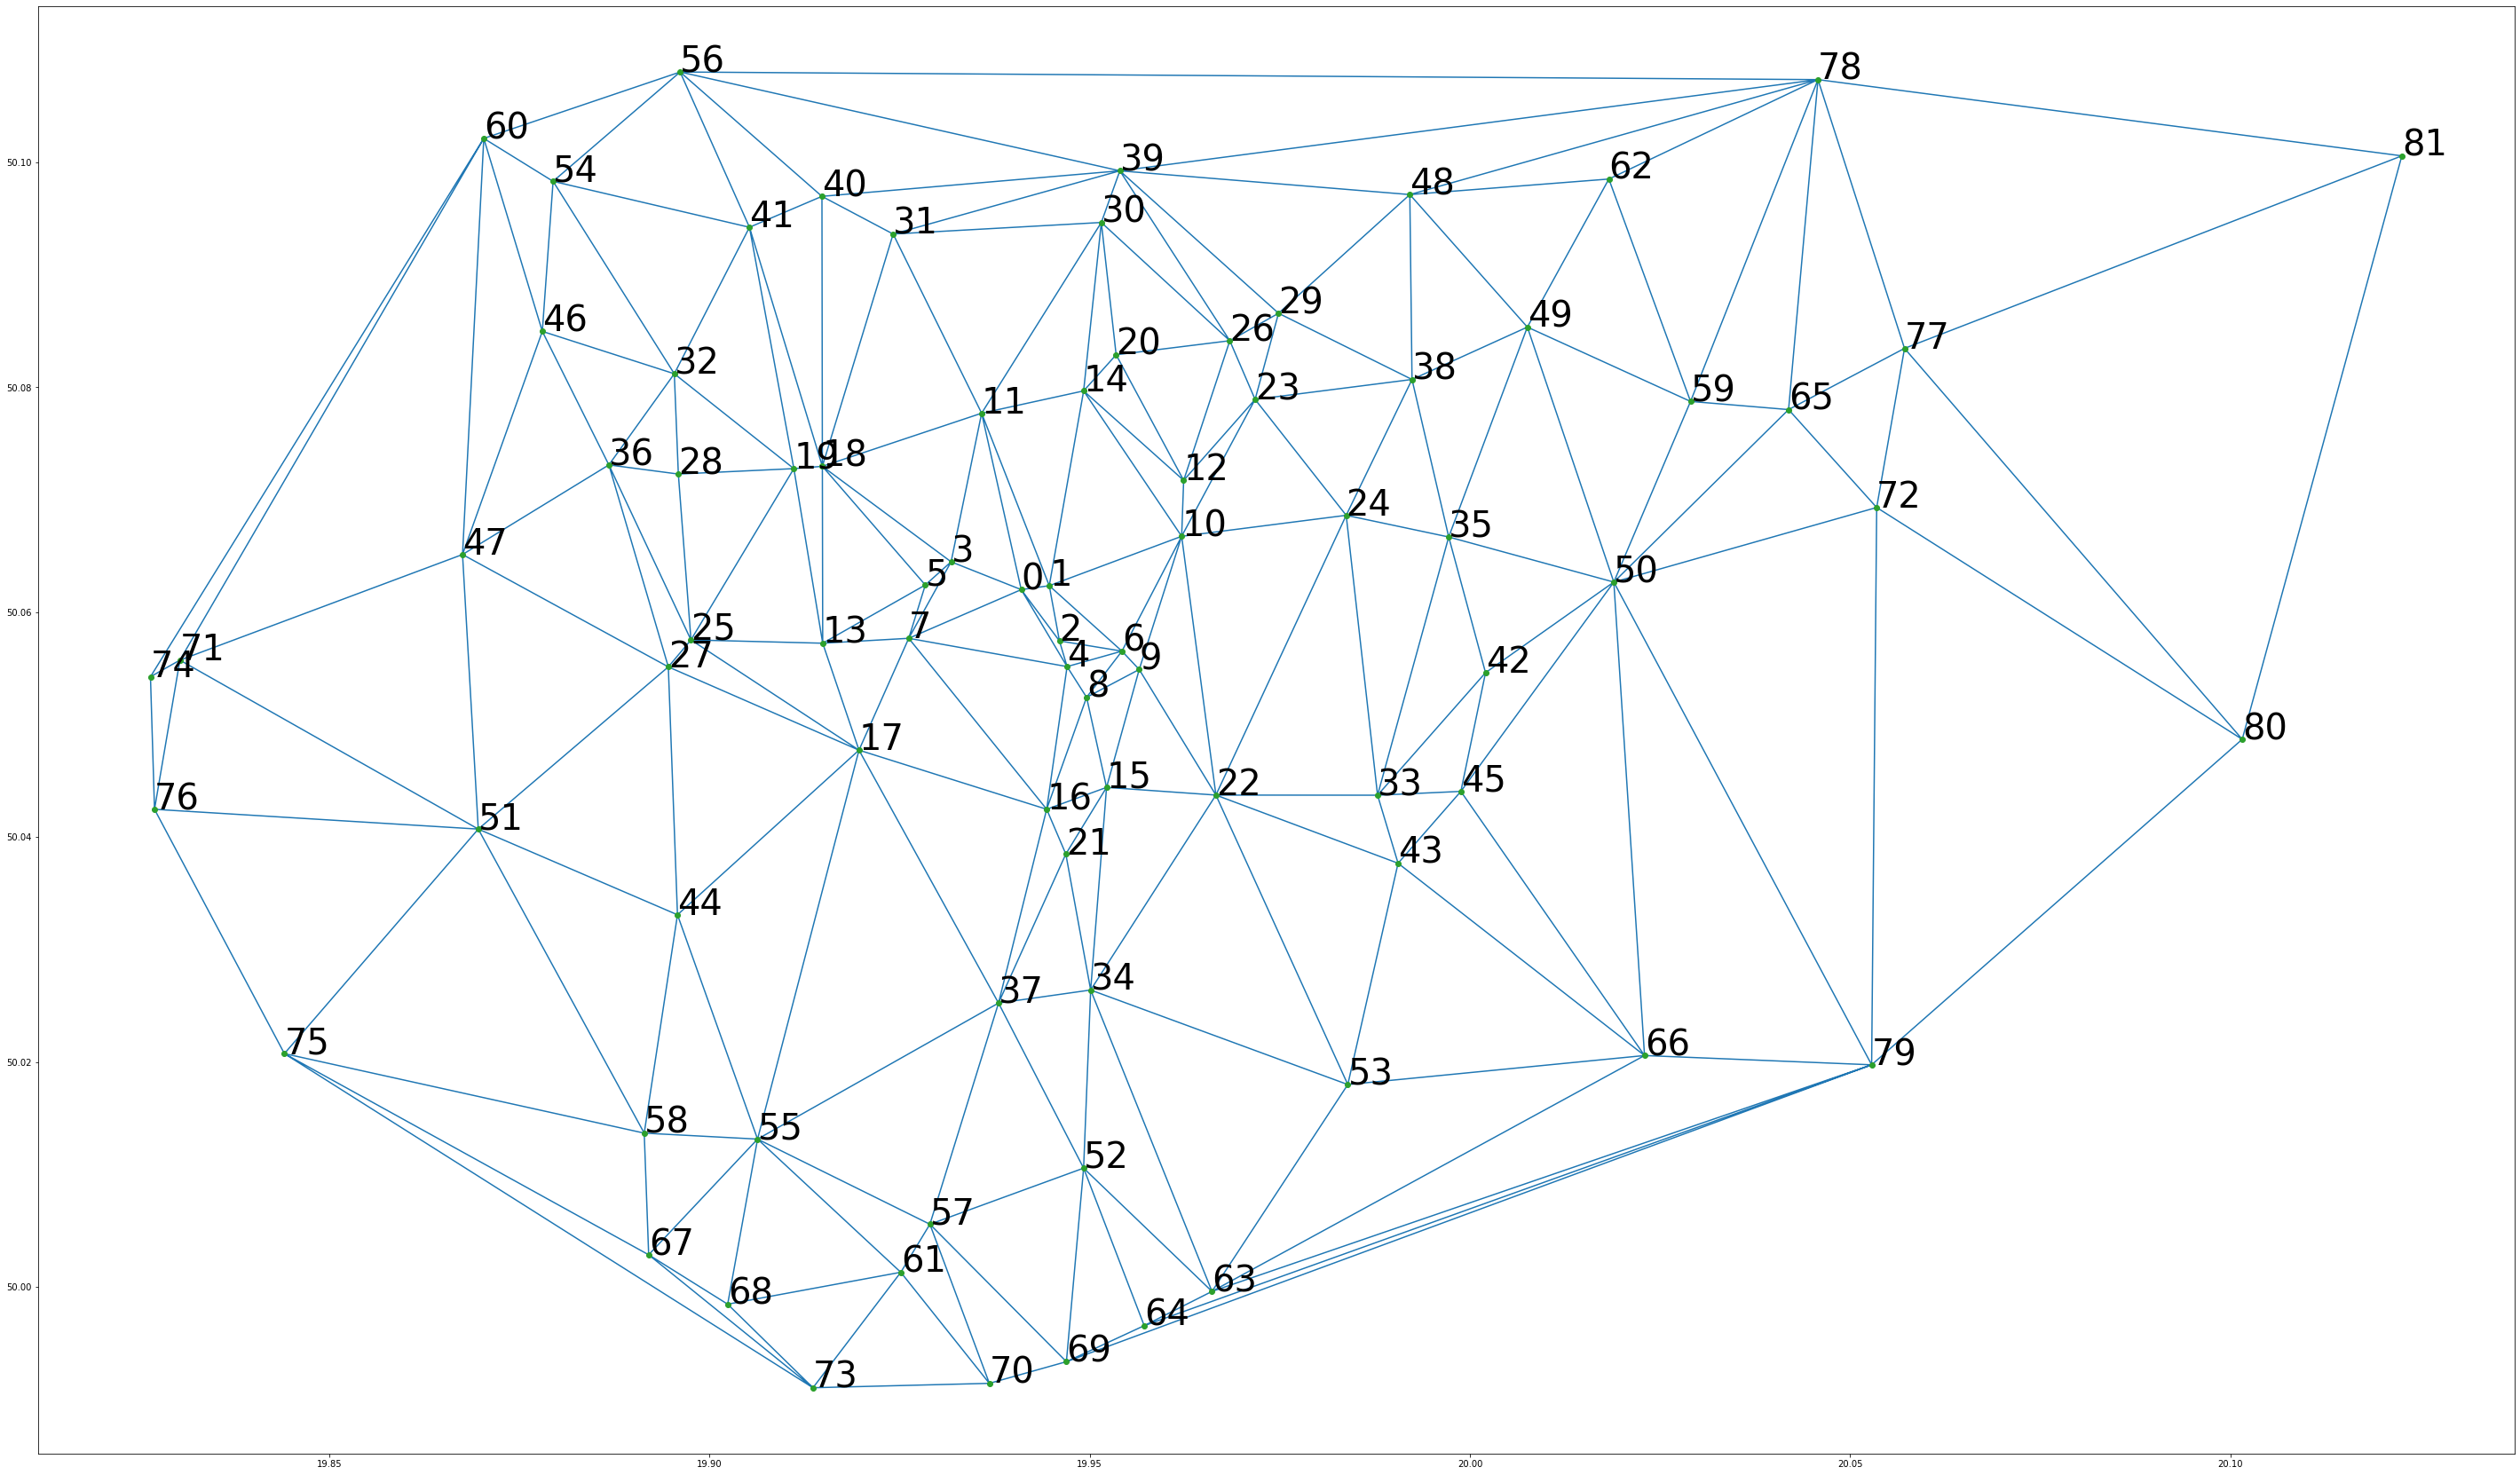

'liczba obszarów: 150'

In [4]:
stations = read_json('stations.json')
stations_map = read_stations(stations)
measures = read_json('measures.json')
STATION_IDS = read_first_measure_ids(measures)
DAYS = extract_days(measures, STATION_IDS[0])
station_with_cords = get_cords(stations_map, STATION_IDS)
triangles = triangulate(station_with_cords)
'liczba obszarów: {}'.format(len(triangles))

## Budowanie macierzy

Postanowiłem załadować zebrane dane w pięciowymiarową macierz, gdzie kolejne wymiary odpowiadają za:
0. obszar
1. dzień pomiaru
2. godzinę pomiaru
3. rodzaj pomiaru
4. aktualna wartość - 0, zmiana wartości - 1, procent normy - 2

dla każdego obszaru wartość pomiaru obliczałem jako średnią z trzech punktów, które zostały użyte do utworzenia obszaru.

dzięki temu będę mógł wybierać w łatwy sposób interesujące mnie dane
np.:
- pomiar PM10 na obszarze nr 2, w dniach od 2 do 4, w godzinach 16-20:
    - ##### M[2, 2:4, 16:20, PM10_DIM, MEASURE_VALUE]
- zmiana temperatury na wszystkich obszarach, we wszystkich dniach, w godzinach 18-20:
    - ##### M[:, :, 18:20, TEMPERATURE, DELTA_MEASURE]
    


In [5]:
def build_measure_matrix(triangles, STATION_IDS, DAYS, MEASURES):
    measures_groupped = {}
    for item in MEASURES:
        measures_groupped.setdefault(item['id'], []).append(item)

    matrix = np.full((len(STATION_IDS), len(DAYS), HOURS, MEASURE_DIM, 2), np.nan)
    for s_idx, station in enumerate(STATION_IDS):
        for measures in measures_groupped[station]:
            if measures is not None:
                m = json.loads(measures['measure'])

                if 'history' in m:
                    for measure in m.get('history'):
                        fromDate = dateutil.parser.parse(measure['fromDateTime'])
                        hour = fromDate.hour
                        date = fromDate.date()
                    
                        if 'values' in measure:
                            for v in measure['values']:
                                if v['name'] == 'PM1':
                                    matrix[s_idx, DAYS.index(date), hour, PM1_DIM] = v['value']
                                elif v['name'] == 'PM10':
                                    matrix[s_idx, DAYS.index(date), hour, PM10_DIM]= v['value']
                                elif v['name'] == 'PM25':
                                    matrix[s_idx, DAYS.index(date), hour, PM25_DIM]= v['value']
                                elif v['name'] == 'PRESSURE':
                                    matrix[s_idx, DAYS.index(date), hour, PRESSURE]=  v['value']
                                elif v['name'] == 'HUMIDITY':
                                    matrix[s_idx, DAYS.index(date), hour, HUMIDITY]=  v['value']
                                elif v['name'] == 'TEMPERATURE':
                                    matrix[s_idx, DAYS.index(date), hour, TEMPERATURE]=  v['value']
                                elif v['name'] == 'CO':
                                    matrix[s_idx, DAYS.index(date), hour, CO_DIM]=  v['value']
                                elif v['name'] == 'NO2':
                                    matrix[s_idx, DAYS.index(date), hour, NO2_DIM]=  v['value']
                                elif v['name'] == 'SO2':
                                    matrix[s_idx, DAYS.index(date), hour, SO2]=  v['value']
                                elif v['name'] == 'O3':
                                    matrix[s_idx, DAYS.index(date), hour, O3]=  v['value']
                                else:
                                    print(v)
    t_matrix = np.full((len(triangles), len(DAYS), HOURS, MEASURE_DIM, 3), np.nan)
    for t_idx, triangle in enumerate(triangles):
        for d_idx, day in enumerate(DAYS):
            for h in range(HOURS):
                d_prev, h_prev = get_prev(day, h)
                d_prev_idx = DAYS.index(d_prev) if d_prev in DAYS else -1
                if d_prev_idx > 0:
                    for m in range(MEASURE_DIM):
                        mean_now = np.nanmean([matrix[s, d_idx, h, m] for s in triangle])
                        mean_norm = mean_now * 100 / float(NORMS_DICT[m])
                        mean_prev = np.nanmean([matrix[s, d_prev_idx, h_prev, m] for s in triangle])
                        delta = mean_now - mean_prev
                        t_matrix[t_idx, d_idx, h, m, DELTA_MEASURE] = delta
                        t_matrix[t_idx, d_idx, h, m, MEASURE_VALUE] = mean_now
                        t_matrix[t_idx, d_idx, h, m, NORMS] = mean_norm
                    
    return t_matrix

In [6]:
if os.path.isfile('measures.mat.npy'):
    measure_matrix = np.load('measures.mat.npy')
else:
    measure_matrix = build_measure_matrix(triangles, STATION_IDS, DAYS, measures)
    np.save('measures.mat', measure_matrix)

(d_s, d_d, d_h, _, _) = measure_matrix.shape
'liczba obszarów: {}, liczba dni: {}'.format(d_s, d_d)

'liczba obszarów: 150, liczba dni: 44'

### Pearson coleration

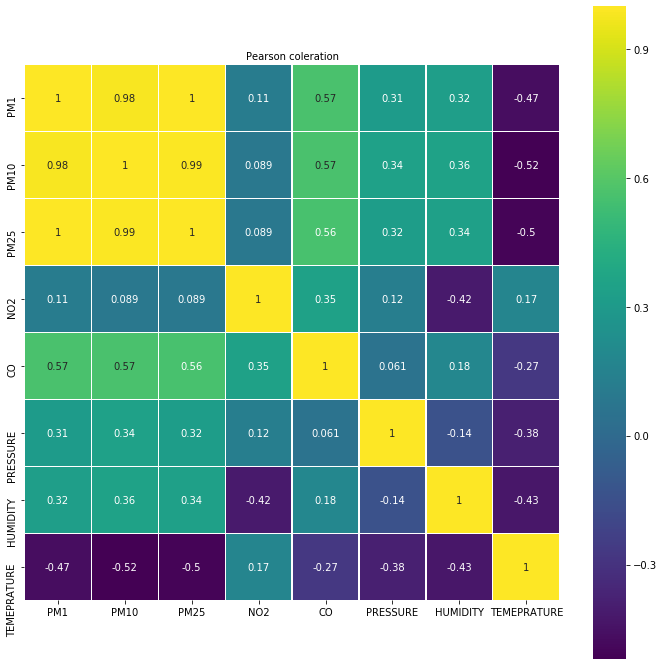

In [8]:
df = pd.DataFrame(data=np.nanmean(measure_matrix[:, :, :, :, MEASURE_VALUE], axis=0).reshape(d_d * d_h, -1)[:, :8],columns=COLUMNS)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title("Pearson coleration", size=10)
seaborn.heatmap(df.corr(), linewidth=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

In [10]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
array = np.nan_to_num(df.values)
array = preprocessing.scale(array)
array.mean(axis=0)
array.shape
pca = PCA()
X_pca = pca.fit_transform(array)
X_pca.shape
x = X_pca[:, 0]
y = X_pca[:, 1]

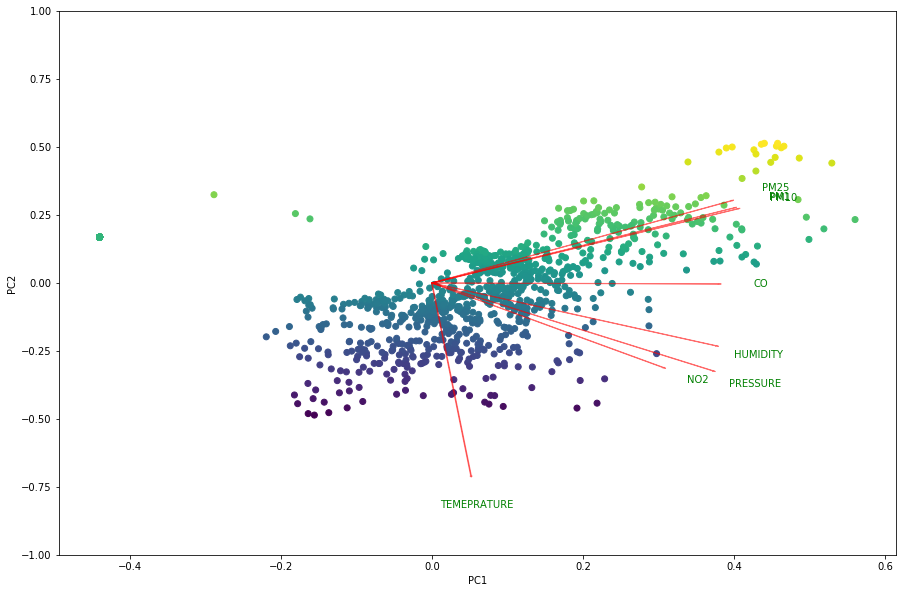

In [11]:
def myplot(score,coeff,labels=None):
    plt.figure(figsize=(15,10))
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
            
attributes = df.columns.values

myplot(X_pca[:,0:3],np.transpose(pca.components_[0:3, :]),attributes)
axes = plt.gca()
axes.set_ylim([-1.0,1.0])
plt.show()

## Dzielenie obszaru Krakowa na pod obszary charakteryzujące się podobną dynamika zmian

Wskaźniki, które mówią o jakości powietrza to:
PM1_DIM = 0
PM10_DIM = 1
PM25_DIM = 2
NO2_DIM = 3
CO_DIM = 4

więc wykonam reshape na macierzy do dwóch wymiarów (obszar, spłaszczona seria pomiarów) i wykonam na takiej macierzy kilka algorytmów klastrujących

In [12]:
def draw_clusters(clusters, triangles, station_with_cords):
    import matplotlib.pyplot as plt
    points = np.array([[station[1]['latitude'], station[1]['longitude']] for station in station_with_cords])
    fig = plt.figure(figsize=(50,30))
    ax = fig.add_subplot(111)
    X = points[:, 1]
    Y = points[:, 0]
    Z = clusters
    cmap = plt.cm.jet  
    bounds = np.linspace(0, np.max(Z) ,np.max(Z) + 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    tpc = plt.tripcolor(X, Y, Z, triangles)
    plt.triplot(X, Y, triangles)
    fig.colorbar(tpc, ticks=bounds).ax.tick_params(labelsize=40)
    plt.plot(X, Y, 'o')
    i = 0
    for xy in zip(X, Y):
        ax.annotate('%s' % i, xy=xy, textcoords='data', size=40)
        i = i + 1
    plt.show()

def draw_clusters_on_map(clusters, triangles, station_with_cords):
    locs = np.array([[station['longitude'], station['latitude']] for _, station in station_with_cords])
    BBox = (locs[:, 0].min(),   locs[:, 0].max(),      
         locs[:, 1].min(), locs[:, 1].max())
    ruh_m = plt.imread('mapa.png')
    fig, ax = plt.subplots(figsize = (50,30))
    X = locs[:, 0]
    Y = locs[:, 1]
    Z = clusters
    cmap = plt.cm.jet  
    bounds = np.linspace(0, np.max(Z) ,np.max(Z) + 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    tpc = plt.tripcolor(X, Y, Z, triangles,alpha=0.4)
    plt.triplot(X, Y, triangles)
    fig.colorbar(tpc, ticks=bounds).ax.tick_params(labelsize=40)
    ax.scatter(locs[:, 0], locs[:, 1], zorder=1, alpha= 0.6, c='b', s=100)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
    i = 0
    for xy in zip(X, Y):  # <--
        ax.annotate('%s' % i, xy=xy, textcoords='data', size=40)
        i = i + 1
    plt.show()

def get_clusters_info(timeseries, clusters):
    print('{}\t\t{}\t\t\t{}\t\t\t{}\t\t\t{}'
             .format('cluster', 'temp', 'hum', 'pm1', 'pm10', 'pm20'))
    for i in range(0, np.max(clusters) + 1):
        areas_idx = np.where(clusters == i)[0]
        means = np.nanmean(timeseries[areas_idx, :, :, :, MEASURE_VALUE], axis=0)
        m_d, m_h, _ = means.shape
        means = np.nanmean(means.reshape(m_d*m_h, -1), axis=0)
        means[TEMPERATURE]
        print('{}\t{}\t{}\t{}\t{}'
             .format(i, means[TEMPERATURE], means[HUMIDITY], means[PM1_DIM], means[PM10_DIM], means[PM25_DIM]))
    

In [22]:
# all stations, all days, all hours, all measures, by norms
flattened_matrix = measure_matrix[:, :, 18:21, PM1_DIM:PM25_DIM + 1, DELTA_MEASURE].reshape(d_s, -1)
flattened_matrix.shape

(150, 396)

## Kmeans

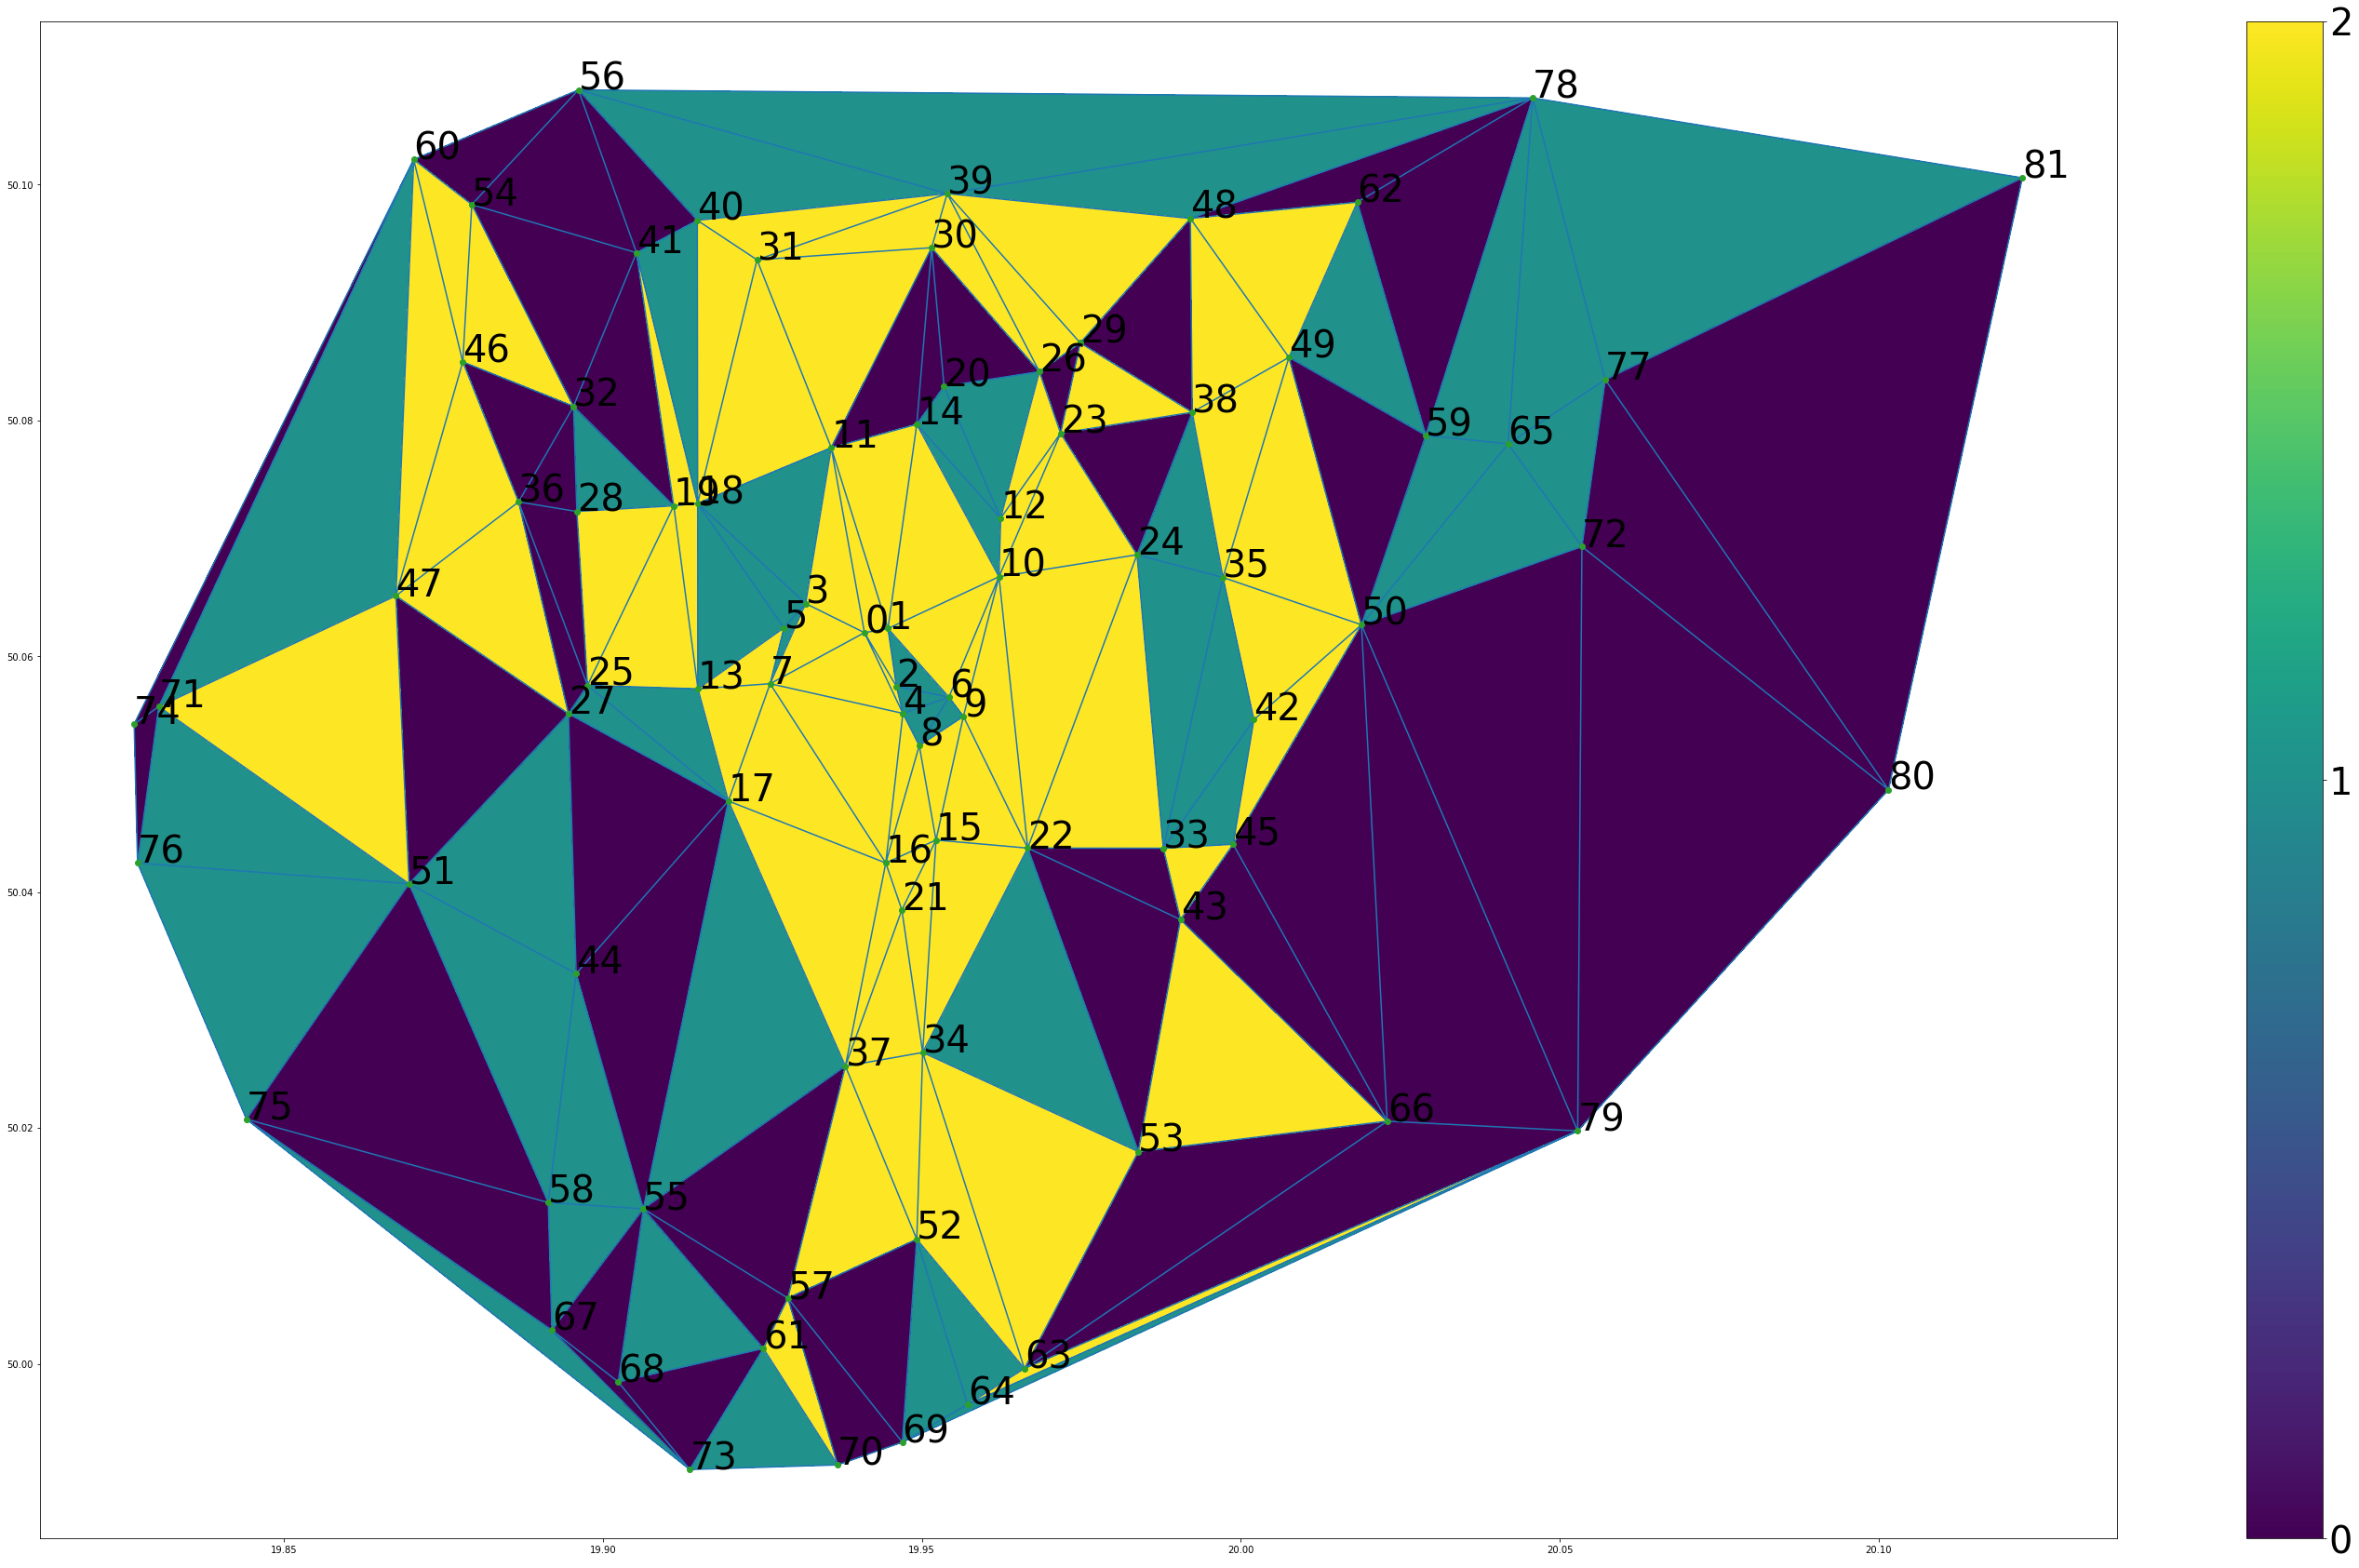

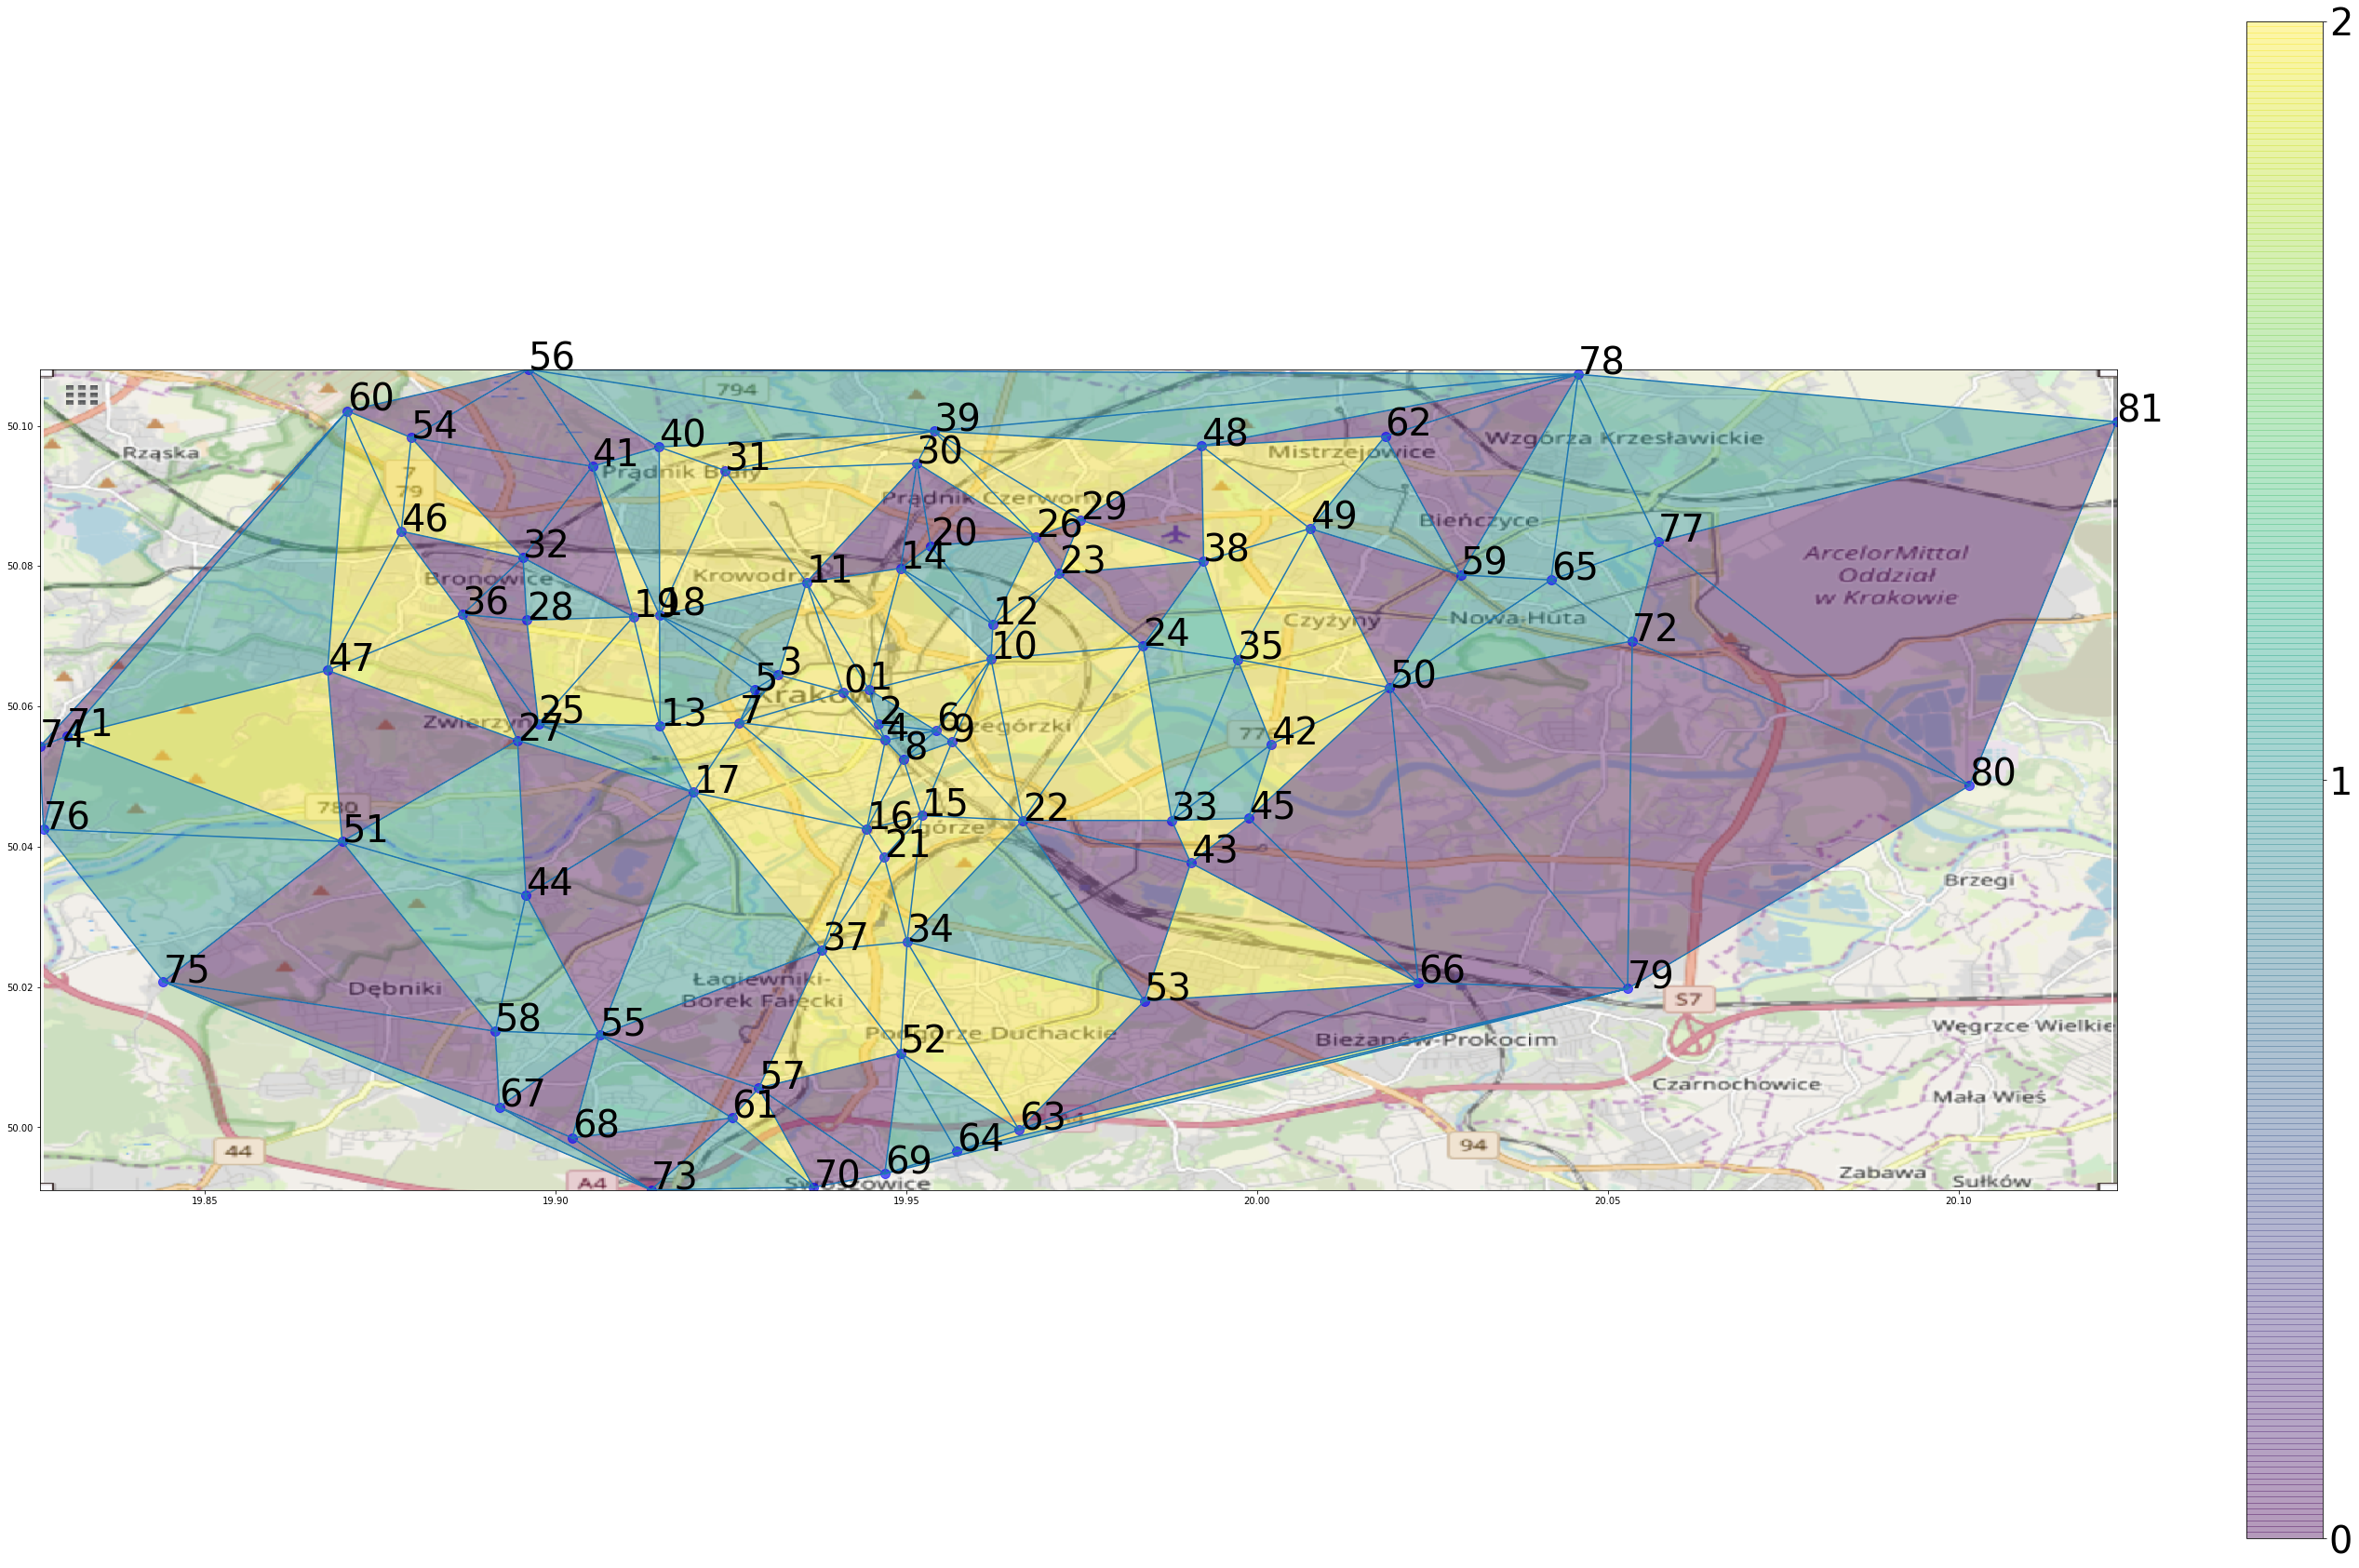

cluster		temp			hum			pm1			pm10
0	5.092174316376041	87.4358378072726	23.8033933669257	67.85118719020187
1	4.98229686058112	90.09767365943387	25.98086555165178	74.87409371797688
2	5.104556914768872	90.43224932360584	23.429711967363968	68.57340761828083


In [23]:
clusters = KMeans(n_clusters=3, random_state=0).fit(np.nan_to_num(flattened_matrix))
draw_clusters(clusters.labels_, triangles, station_with_cords)
draw_clusters_on_map(clusters.labels_, triangles, station_with_cords)
get_clusters_info(measure_matrix[:, :, 18:21, :, :], clusters.labels_ )

## AgglomerativeClustering

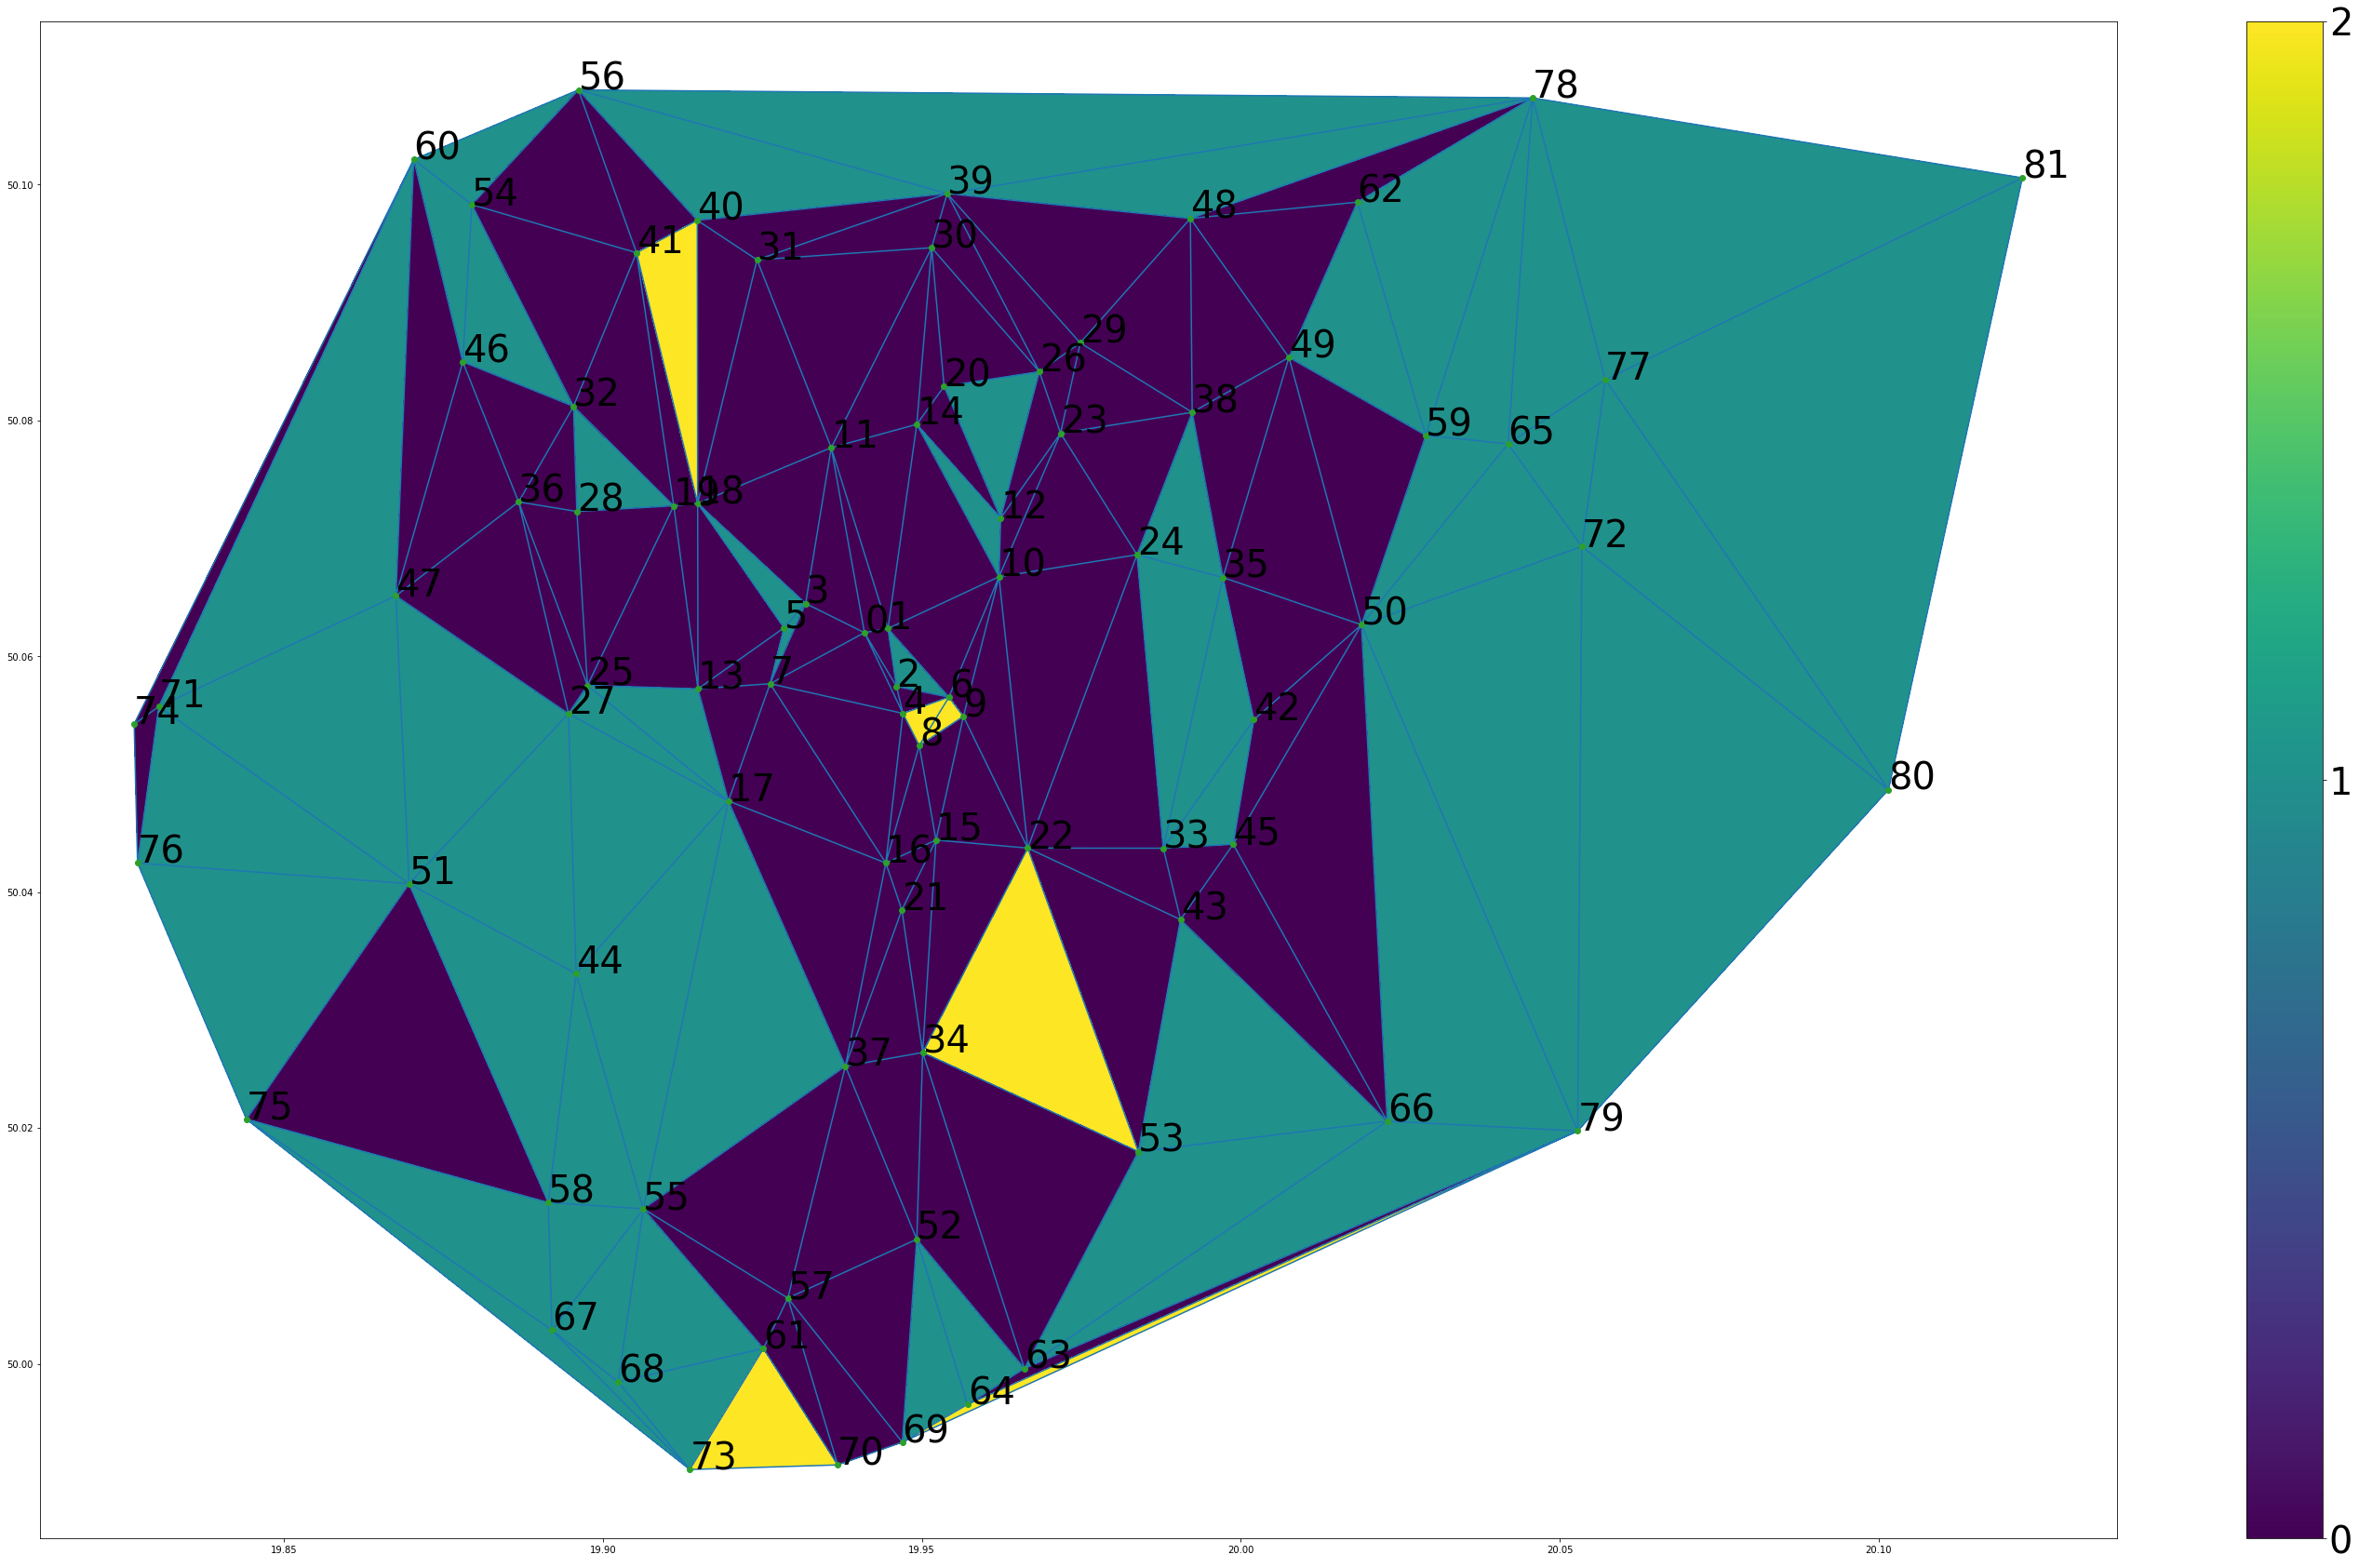

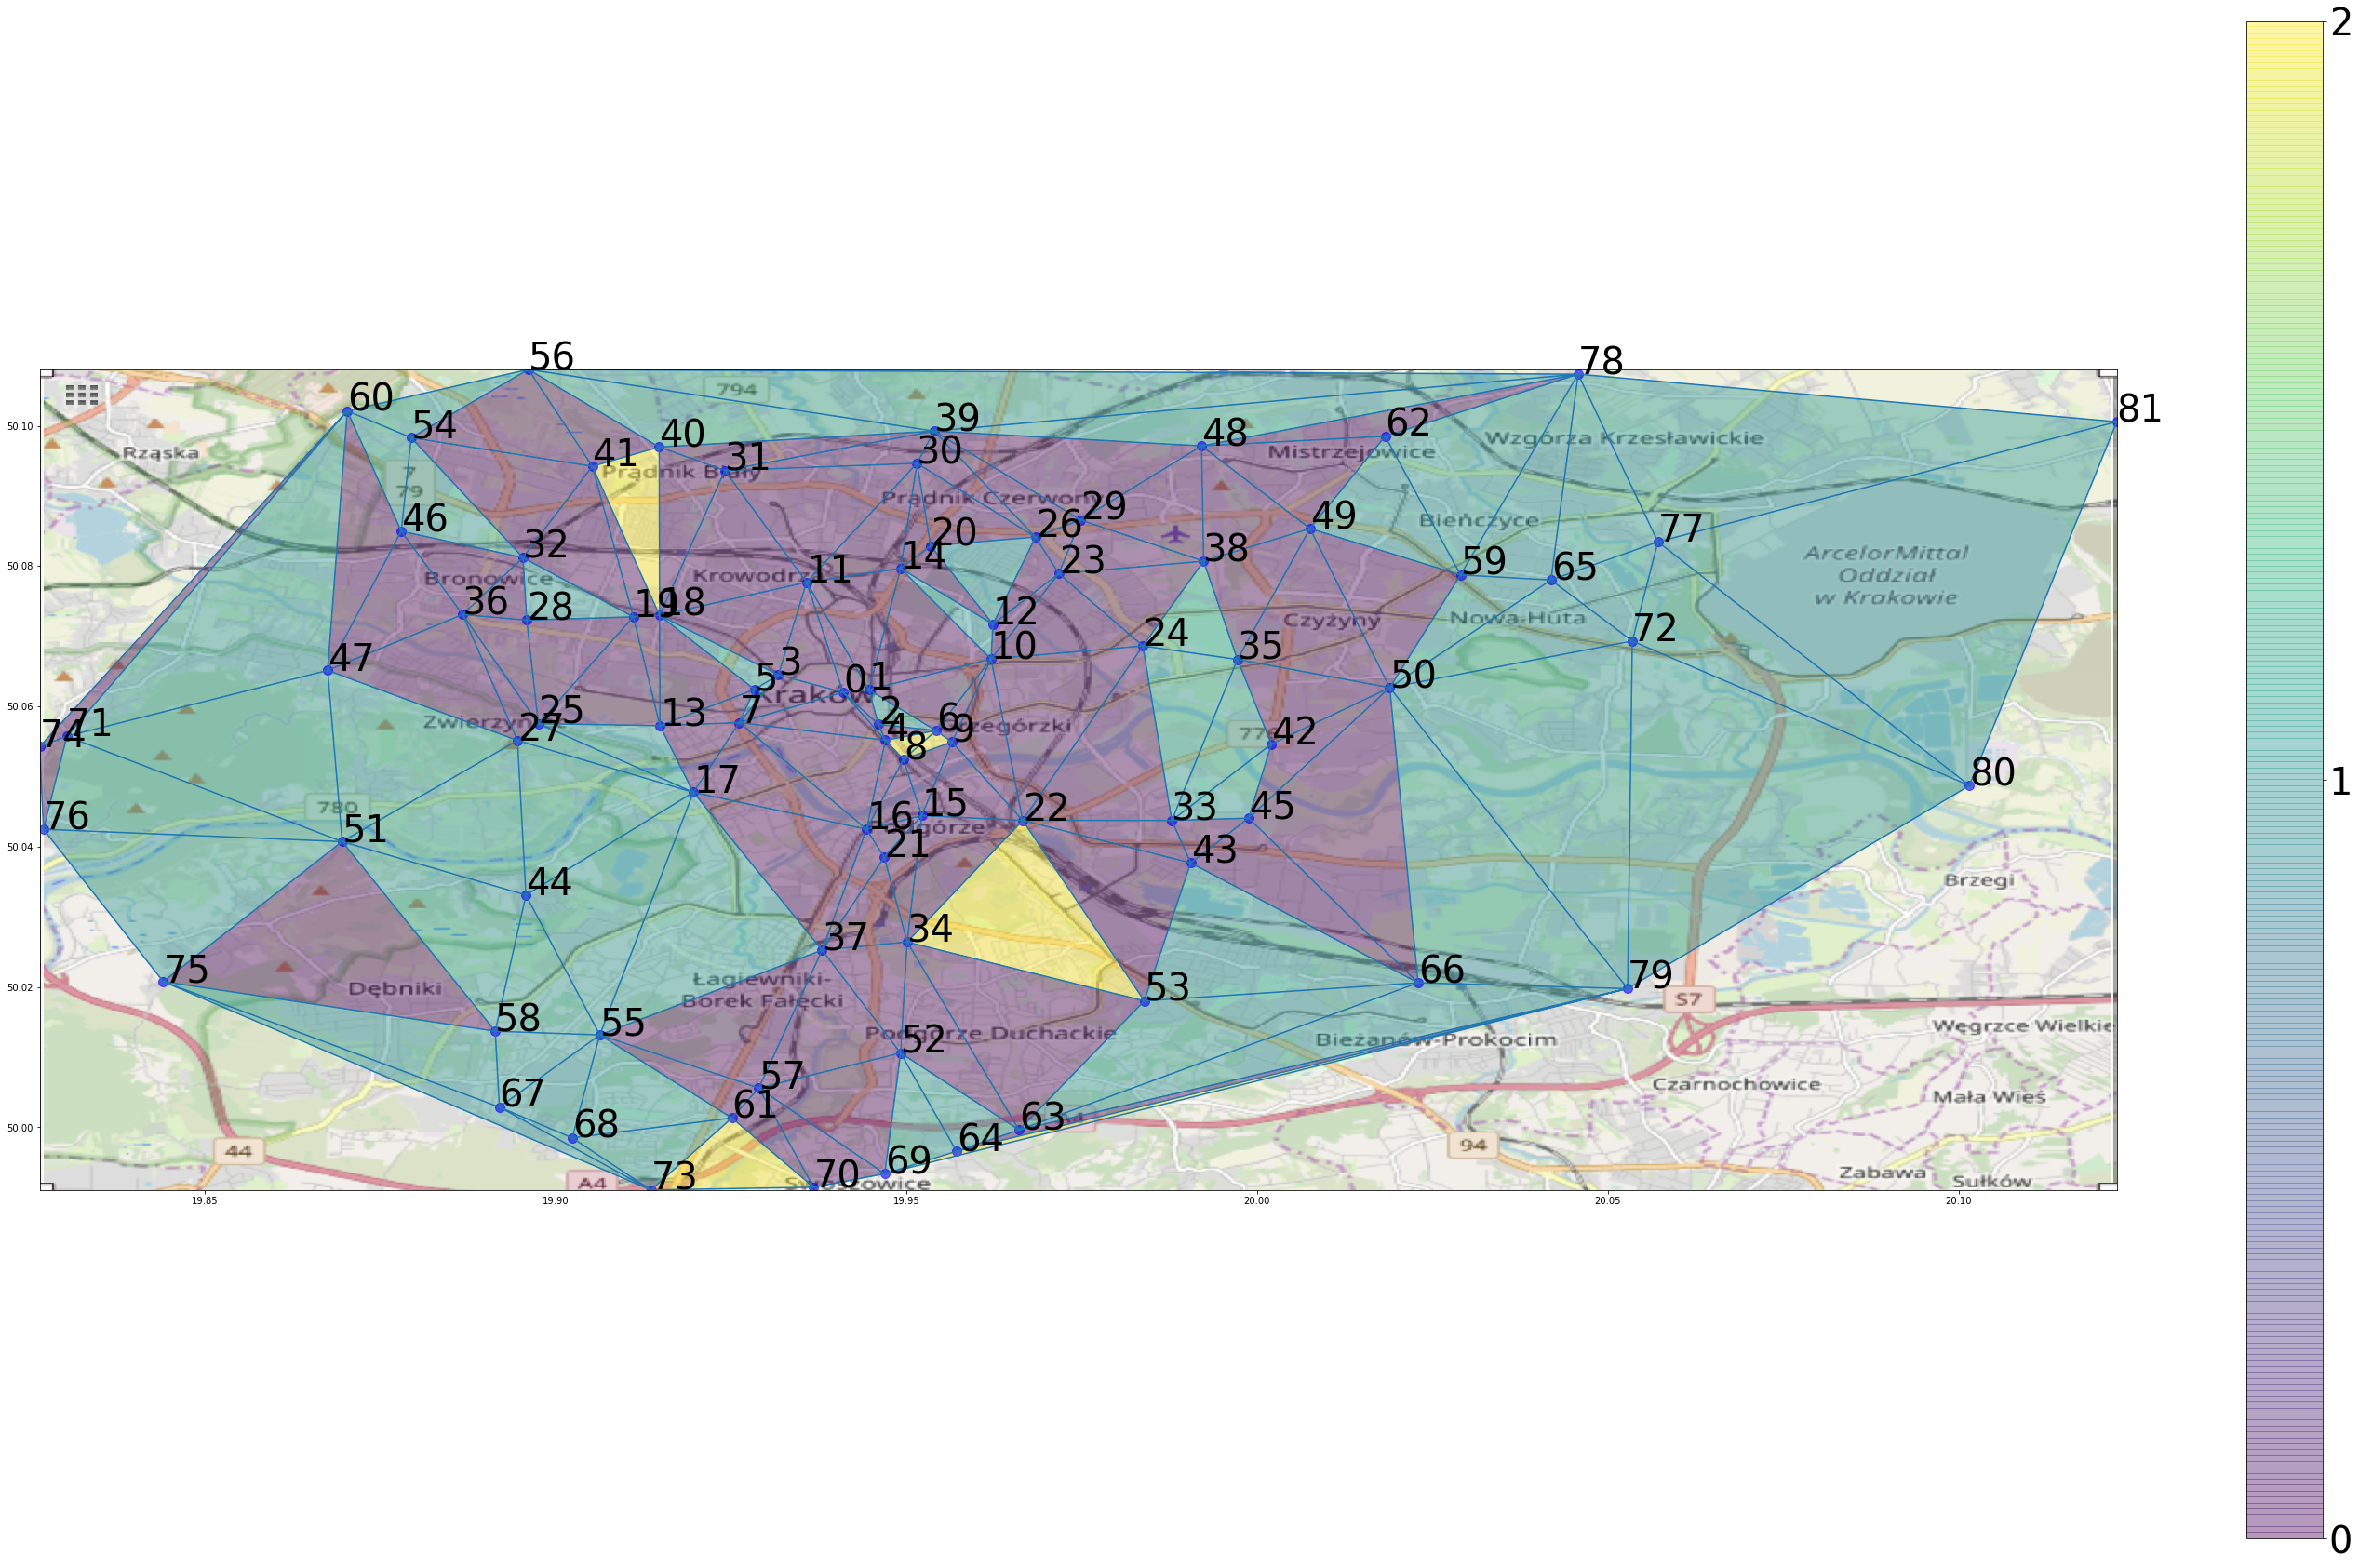

cluster		temp			hum			pm1			pm10
0	5.138575186880008	90.23139160490403	23.68923545409448	68.9659629213248
1	4.9580604875850485	88.52719281806988	24.55410730927287	70.83184853855994
2	4.915842592592591	86.48925617283949	30.876271135265707	85.50840277777776


In [33]:
clusters = AgglomerativeClustering(n_clusters=3).fit(np.nan_to_num(flattened_matrix))
draw_clusters(clusters.labels_, triangles, station_with_cords)
draw_clusters_on_map(clusters.labels_, triangles, station_with_cords)
get_clusters_info(measure_matrix[:, :, 18:21, :, :], clusters.labels_ )

## Wskaźniki ilościowe jakości powietrza (na podobszar)

#### Najdłuższy ciągły okres, w którym norma została przekroczona w danych podobszarze (rozdzielczość godzinowa)

In [16]:
def max_time_range_when_norm_exceed(matrix, areas_idx, measure):
    mean = np.nanmean(matrix[areas_idx, :, :, measure, NORMS].reshape(len(areas_idx), -1), axis=0)
    total_mean = np.nanmean(mean)
    x = np.nan_to_num(mean, nan=total_mean) > 100
    idx_pairs = np.where(np.diff(np.hstack(([False],x==True,[False]))))[0].reshape(-1,2)
    start, end = idx_pairs[np.diff(idx_pairs,axis=1).argmax()]
    hours = end - start
    mean = np.nanmean(mean[start:end])
    start = get_date_time(int(start) // 24, int(start) % 24)
    end = get_date_time(int(end) // 24, int(end) % 24)
    return hours, start, end, mean
   

In [17]:
areas_idx = np.where(clusters.labels_ == 1)[0]

In [18]:
hours, start, end, mean = max_time_range_when_norm_exceed(measure_matrix, areas_idx, PM10_DIM)
'Norm exceeded for {} hours in range({}, {}) with mean {}'.format(hours, start, end, mean)

'Norm exceeded for 163 hours in range(2019-11-21 11:00:00, 2019-11-28 06:00:00) with mean 303.7066556108347'

#### Najgorsza średnia jakość powietrza

In [19]:
def worst_mean_air_quality(matrix, areas_idx, start, end, measure):
    s_d_idx, s_h_idx =  get_day_idx(start)
    e_d_idx, e_h_idx =  get_day_idx(end)
    s_idx = s_d_idx * 24 + s_h_idx
    e_idx = e_d_idx * 24 + e_h_idx
    print(s_idx, e_idx)
    mean = np.nanmean(matrix[areas_idx, :, :, measure, NORMS].reshape(len(areas_idx), -1)[:, s_idx:e_idx], axis=0)
    worst = int(np.nanargmax(mean) + s_idx)
    date = get_date_time(worst // 24, worst % 24)
    return date, np.nanmax(mean)

In [20]:
date, norm= worst_mean_air_quality(measure_matrix, 
                                           areas_idx,
                       datetime.datetime(2019, 11, 1, 23, 0, 0),
                       datetime.datetime(2019, 12, 5, 23, 0, 0),
                       PM10_DIM)
'The worst air quality was registered at {} with value {} % of norm'.format(date, norm)

239 1055


'The worst air quality was registered at 2019-12-04 02:00:00 with value 628.5239800995025 % of norm'